In [1]:
import os
import sys
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
class LeNet5(torch.nn.Module):          
    def __init__(self):
        self.linear_dim = 16384
        
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2 , bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        self.fc1 = torch.nn.Linear(self.linear_dim, 1024)
        self.fc3 = torch.nn.Linear(1024, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x) 
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, self.linear_dim)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc3(x)
        return x


In [3]:
class Network_BareANN(nn.Module):
    def __init__(self):
        super(Network_BareANN, self).__init__()
        self.linear_dim = 131072
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.fc1 = nn.Linear(self.linear_dim, 10, bias=False)

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.linear_dim)
        x = self.fc1(x)
        return x


In [4]:
class Network_ANN(nn.Module):
    def __init__(self):
        super(Network_ANN, self).__init__()
        self.linear_dim = 8192
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.subsample1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.subsample2 = nn.MaxPool2d(2, 2, 0)
        self.fc1 = nn.Linear(self.linear_dim, 10, bias=False)
        self.HalfRect3 = nn.ReLU()

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input):
        x = self.conv1(input)
        x = self.HalfRect1(x)
        x = self.dropout1(x)
        x = self.subsample1(x)
        x = self.conv2(x)
        x = self.HalfRect2(x)
        x = self.dropout2(x)
        x = self.subsample2(x)
        x = x.view(-1, self.linear_dim)
        x = self.fc1(x)
        return x

    def normalize_nn(self, train_loader):
        conv1_weight_max = torch.max(F.relu(self.conv1.weight))
        conv2_weight_max = torch.max(F.relu(self.conv2.weight))
        fc1_weight_max = torch.max(F.relu(self.fc1.weight))
        conv1_activation_max = 0.0
        conv2_activation_max = 0.0
        fc1_activation_max = 0.0

        self.eval()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            x = inputs.float().to(self.device)
            x = self.dropout1(self.HalfRect2(self.conv1(x)))
            conv1_activation_max = max(conv1_activation_max, torch.max(x))
            x = self.subsample1(x)
            x = self.dropout2(self.HalfRect2(self.conv2(x)))
            conv2_activation_max = max(conv2_activation_max, torch.max(x))
            x = self.subsample2(x)
            x = x.view(-1, self.linear_dim)
            x = self.HalfRect3(self.fc1(x))
            fc1_activation_max = max(fc1_activation_max, torch.max(x))
        self.train()

        self.factor_log = []
        previous_factor = 1

        scale_factor = max(conv1_weight_max, conv1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.conv1.weight.data = self.conv1.weight.data / applied_inv_factor
        self.factor_log.append(1/ applied_inv_factor)
        previous_factor = applied_inv_factor

        scale_factor = max(conv2_weight_max, conv2_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.conv2.weight.data = self.conv2.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = applied_inv_factor

        scale_factor = max(fc1_weight_max, fc1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.fc1.weight.data = self.fc1.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = applied_inv_factor
        

In [5]:
class STDB(torch.autograd.Function):
    
    alpha = ''
    beta = ''
    
    @staticmethod
    def forward(ctx, input, last_spike):
        ctx.save_for_backward(last_spike)
        out = torch.zeros_like(input).to(device)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        last_spike, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = STDB.alpha * torch.exp(-1*last_spike)**STDB.beta
        return grad*grad_input, None

    
def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp).to(device)
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))


In [6]:
class Network_SNN(nn.Module):
    def __init__(self, time_window=30, max_rate=200, threshold=1.0, leak_factor=1.0, alpha=0.3, beta=0.01) -> None:
        super(Network_SNN, self).__init__()
        
        self.image_size = 64
        self.linear_dim = 8192
        
        self.leak_factor = leak_factor
        self.threshold = threshold
        self.spike = None
        
        self.spike_fn = STDB.apply
        STDB.alpha = alpha
        STDB.beta = beta 
        
        self.time_window = time_window
        self.dt = 0.001
        self.max_rate = max_rate
        self.rescale_factor = 1.0/(self.dt*self.max_rate)
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.subsample1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.subsample2 = nn.MaxPool2d(2, 2, 0)
        self.fc1 = nn.Linear(self.linear_dim, 10, bias=False)
        self.HalfRect3 = nn.ReLU()
        
        self.conv_list = [self.conv1, self.conv2]
        self.pool_list = [self.subsample1, self.subsample2]
        
        for m in self.modules():
            if (isinstance(m, nn.Conv2d)):
                m.threshold = self.threshold
            elif (isinstance(m, nn.Linear)):
                m.threshold = self.threshold

    def to(self, device):
        self.device = device
        super().to(device)
        return self
    
    def init_spike(self, mem_conv_list):
        spike = [copy.deepcopy(i) for i in mem_conv_list]
        for values in spike:
            for value in values:
                value.fill_(-1000)
        self.spike = spike
    
    def forward(self, input):
        infer, _input = input
        batch_size = _input.size(0)
        
        input_spksum = torch.zeros(batch_size, self.conv1.in_channels, self.image_size, self.image_size).to(device)    
        mem_conv1 = torch.zeros(batch_size, self.conv1.out_channels, 64, 64).to(device)
        mem_conv2 = torch.zeros(batch_size, self.conv2.out_channels, 32, 32).to(device)
        mem_fc1 = torch.zeros(batch_size, self.fc1.out_features).to(device)
        mem_conv_list = [mem_conv1, mem_conv2]
        self.init_spike(mem_conv_list)
        
        for t in range(self.time_window):
            
            if infer == 'Synth':
                _t = _input[:,t].view(batch_size, 1, self.image_size, self.image_size)
            else:
                _t = _input.view(batch_size, 1, self.image_size, self.image_size)
                
            spike_input = PoissonGen(_t.to(device), self.rescale_factor)
            input_spksum += spike_input
            out_prev = spike_input
            
            for idx in range(len(self.conv_list)):                
                mem_conv_list[idx] = self.leak_factor * mem_conv_list[idx] + self.conv_list[idx](out_prev)
                mem_thr = (mem_conv_list[idx] / self.conv_list[idx].threshold) - 1.0
                out = self.spike_fn(mem_thr, (t-1-self.spike[idx]))
                rst = torch.zeros_like(mem_conv_list[idx]).to(device)
                rst[mem_thr > 0] = self.conv_list[idx].threshold
                self.spike[idx] = self.spike[idx].masked_fill(out.bool(),t-1)
                mem_conv_list[idx] = mem_conv_list[idx] - rst
                out_prev = out.clone()
                
                out_prev = self.pool_list[idx](out_prev)
            
            out_prev = out_prev.reshape(batch_size, -1)
            
            mem_fc1 = mem_fc1 + self.fc1(out_prev)

        out_voltage = mem_fc1 / self.time_window

        return input_spksum, out_voltage


In [7]:
class BouncingMNISTDataHandler(object):
    def __init__(self, batch_size, seq_length, image_size, path='', pertubation=False, attack_info={}, digit_size=28) -> None:
        self.seq_length_ = seq_length
        self.batch_size_ = batch_size
        self.image_size_ = image_size
        self.num_digits_ = 1
        self.step_length_ = 0.1
        self.digit_size_ = digit_size
        self.frame_size_ = self.image_size_ ** 2
        self.pertubation = pertubation
        self.raw_ = False
            
        if not self.pertubation:
            try:
                f = h5py.File(path)
            except:
                print('Please set the correct path to MNIST dataset')
                sys.exit(0)
                
            self.data_ = f['inputs'][:].reshape(-1, self.digit_size_, self.digit_size_)
            self.labels_ = f['labels'][:][0]
            f.close()
        else:
            data_loader, epsilon = attack_info['data_loader'], attack_info['pertubation_strength']
            _X, _y = GenerateAdvExamples(attack_info['model'], data_loader, img_size=self.digit_size_, epsilon=epsilon)
            self.data_ = _X.numpy()
            self.labels_ = _y.numpy()
            self.raw_ = attack_info['raw']

        self.indices_ = np.arange(self.data_.shape[0])
        self.row_ = 0
        np.random.shuffle(self.indices_)
    
    def GetRandomTrajectory(self, batch_size):
        length = self.seq_length_
        canvas_size = self.image_size_ - self.digit_size_
    
        # Initial position uniform random inside the box.
        y = np.random.rand(batch_size)
        x = np.random.rand(batch_size)

        # Choose a random velocity.
        theta = np.random.rand(batch_size) * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros((length, batch_size))
        start_x = np.zeros((length, batch_size))
        for i in range(length):
          # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_
            
            # Bounce off edges.
            for j in range(batch_size):
                if x[j] <= 0:
                    x[j] = 0
                    v_x[j] = -v_x[j]
                if x[j] >= 1.0:
                    x[j] = 1.0
                    v_x[j] = -v_x[j]
                if y[j] <= 0:
                    y[j] = 0
                    v_y[j] = -v_y[j]
                if y[j] >= 1.0:
                    y[j] = 1.0
                    v_y[j] = -v_y[j]
            start_y[i, :] = y
            start_x[i, :] = x
        
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x
    
    def Overlap(self, a, b):
        """ Put b on top of a."""
        if not self.raw_:
            return np.maximum(a, b)
        return b

    def GetBatch(self, verbose=False):
        start_y, start_x = self.GetRandomTrajectory(self.batch_size_ * self.num_digits_)
        # minibatch data
        data = np.zeros((self.batch_size_, self.seq_length_, self.image_size_, self.image_size_), dtype=np.float32)
        labels = np.zeros((self.batch_size_))

        for j in range(self.batch_size_):
            for n in range(self.num_digits_):

                # get random digit from dataset
                ind = self.indices_[self.row_]
                self.row_ += 1
                if self.row_ == self.data_.shape[0]:
                    self.row_ = 0
                    np.random.shuffle(self.indices_)
                digit_image = self.data_[ind, :, :]
                labels[j] = self.labels_[ind]

                # generate video
                for i in range(self.seq_length_):
                    top    = start_y[i, j * self.num_digits_ + n]
                    left   = start_x[i, j * self.num_digits_ + n]
                    bottom = top  + self.digit_size_
                    right  = left + self.digit_size_
                    data[j, i, top:bottom, left:right] = self.Overlap(data[j, i, top:bottom, left:right], digit_image)

        return data.reshape(self.batch_size_, -1), labels


In [8]:
def OrdinEval(model, params, train_loader=None, test_loader=None, arc='ANN'):
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for split, loader in [('Train', train_loader), ('Test', test_loader)]:
            if loader is not None:
                for batch_idx, (inputs, targets) in enumerate(loader):
                    batch_sz = inputs.size(0)            
                    inputs = inputs.float().to(device)
                    labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

                    if arc == 'SNN':
                        _, outputs = model((params['infer_type'], inputs))
                    else:
                        outputs = model(inputs)
                    targets = targets.to(device)

                    loss = params['criterion'](outputs, labels_)
                    _, predicted = outputs.max(1)
                    total += float(targets.size(0))
                    correct += float(predicted.eq(targets).sum().cpu().item())
                print(arc, split, "Acc: %.3f" % (100 * correct / total), end=' | ')
                acc = 100. * float(correct) / float(total)
                acc_record.append(acc)


def OrdinTrainNEval(model, params, train_loader, test_loader, arc='ANN', verbose_interval=4):
    print(model, '\nParameter Count:', sum(p.numel() for p in model.parameters() if p.requires_grad),
          '\n\n','**********',arc,'Training **********')
    verbose_at = [int(len(train_loader)*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i, (inputs, targets) in enumerate(train_loader):
            batch_sz = inputs.size(0)
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            if arc == 'SNN':
                _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs)
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('\nEpoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1, params['num_epochs'], i+1, len(train_loader),running_loss,time.time()-start_time), end=' | ')
                running_loss = 0
        OrdinEval(model, params, train_loader, test_loader, arc)


In [9]:
def displaySeq(images, titles=None, num_rows=2, num_cols=None):
    num_images = len(images)
    if num_cols is None:
        num_cols = math.ceil(num_images / num_rows)

    figsize = (num_cols * 2, num_rows * 2)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, image in enumerate(images):
        row = i // num_cols
        col = i % num_cols

        if num_rows > 1:
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            if titles is not None:
                axes[row, col].set_title(titles[i])
        else:
            axes[col].imshow(image, cmap='gray')
            axes[col].axis('off')
            if titles is not None:
                axes[col].set_title(titles[i])

    plt.tight_layout()
    plt.show()

    
def DataPreview(data):
    print(data.shape)
    displaySeq(data[random.randint(0, data.shape[0]-1)])
    
    
def setSNN_Params(model, model_params, time_window=30, max_rate=800):
    model.time_window = time_window
    model.max_rate = max_rate
    model.rescale_factor = 1.0/(model.dt*model.max_rate)

    model_params['seq_length'] = model.time_window
    return time_window

In [10]:
def SynthEval(MovingMNIST, model, params, arc='SNN', data_preview=False, eval_size=0.2, batch_scale_factor=2):
    MovingMNIST.batch_size_ *= batch_scale_factor
    img_size = MovingMNIST.image_size_
    
    model.eval()
    acc_record = list([])
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(int(params['num_batches']*eval_size)):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if data_preview and not i and arc == 'SNN' and params['infer_type'] == 'Synth':
                print('\n', '********** Data Preview **********')
                DataPreview(inputs)
           
            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            if arc == 'SNN':
                if params['infer_type'] == 'Ordin':
                    _, outputs = model((params['infer_type'], inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1)))
                else:
                    _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1))
            targets = targets.to(device)

            loss = params['criterion'](outputs, labels_)
            _, predicted = outputs.max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().cpu().item())
            
        print("SNN Test Accuracy: %.3f" % (100 * correct / total), end=' | ')
        acc = 100. * float(correct) / float(total)
        acc_record.append(acc)
        MovingMNIST.batch_size_ //= batch_scale_factor

        
def SynthTrainNEval(MovingMNIST, model, params, arc='SNN', verbose_interval=4):
    print(model)
    img_size = MovingMNIST.image_size_
    verbose_at = [int(params['num_batches']*i/verbose_interval) for i in range(1, verbose_interval+1)]

    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0
        start_time = time.time()

        for i in range(params['num_batches']):
            X, y = MovingMNIST.GetBatch()
            batch_sz = X.shape[0]
            inputs = torch.from_numpy(X).reshape(batch_sz, params['seq_length'], img_size, img_size)
            targets = torch.from_numpy(y).reshape(-1).to(torch.int64)
            
            if not epoch and not i:
                if arc == 'SNN' and params['infer_type'] == 'Synth':
                    print(' ********** Data Preview **********')
                    DataPreview(inputs)
                print(' **********', arc,'Training **********')

            inputs = inputs.float().to(device)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            params['optimizer'].zero_grad()
            if arc == 'SNN':
                if params['infer_type'] == 'Ordin':
                    _, outputs = model((params['infer_type'], inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1)))
                else:
                    _, outputs = model((params['infer_type'], inputs))
            else:
                outputs = model(inputs[:, random.randint(0, params['seq_length']-1)].unsqueeze(1))
                
            loss = params['criterion'](outputs, labels_)
            running_loss += loss.cpu().item()
            loss.backward()
            params['optimizer'].step()
            if i+1 in verbose_at:
                print ('\nEpoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                      %(epoch+1,params['num_epochs'],i+1, params['num_batches'],running_loss,time.time()-start_time), end=' | ')
                running_loss = 0
        SynthEval(MovingMNIST, model, params, arc=arc)


In [11]:
def PerturbedOrdinEval(substitute, target, target_params, dataloader, arc='ANN',
    attack_info={'epsilon' : 0.3, 'alpha' : 0.01, 'iterations' : 40}) -> None:
    acc_hist = {}
    
    eps = attack_info['epsilon']
    alpha = attack_info['alpha']
    iters = attack_info['iterations']

    target_params['infer_type'] = 'Ordin'
    for adv_func in ['fast_gradient_method', 'projected_gradient_descent']:
        target.eval()
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            batch_sz = inputs.size(0)            
            inputs = inputs.float().to(device)
            if adv_func == 'fast_gradient_method':
                perturbed_inputs = fast_gradient_method(substitute, inputs, eps, np.inf)
            else:
                perturbed_inputs = projected_gradient_descent(substitute, inputs, eps, alpha, iters, np.inf)
            labels_ = torch.zeros(batch_sz, 10).scatter_(1, targets.view(-1, 1), 1).to(device)

            if arc == 'SNN':
                _, outputs = target((target_params['infer_type'], perturbed_inputs))
            else:
                outputs = target(perturbed_inputs)
            targets = targets.to(device)

            loss = target_params['criterion'](outputs, labels_)
            _, predicted = outputs.max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().cpu().item())

        print(arc, '('+adv_func+')','Perturbed Data', "Accuracy: %.3f" % (100 * correct / total))
        acc = 100. * float(correct) / float(total)
        acc_hist[adv_func] = acc
    
    return acc_hist


In [12]:
def mnist_transform(img_size, default=28):
    pad_xy = (img_size - default) // 2
    return transforms.Compose([
        transforms.Pad((pad_xy, pad_xy)),
        transforms.ToTensor()
    ])


img_size = 64
train_batch_size = 100
test_batch_size = train_batch_size * 2

mnist_train_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=True, download=True, transform=mnist_transform(img_size))
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=train_batch_size, shuffle=True)

mnist_test_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=False, download=True, transform=mnist_transform(img_size))
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=test_batch_size, shuffle=False)


# import shutil
# shutil.rmtree('/kaggle/working/D:\Dataset\mnist')

In [13]:
def AttackNetworks(substitute, target, target_params, epsilon_range=np.arange(0, 0.35, 0.05), arc='ANN'):
    acc_hist = {'fast_gradient_method' : [], 'projected_gradient_descent' : []}

    for eps in epsilon_range:
        print('Perturbation Strength:', eps)
        inter_hist = PerturbedOrdinEval(substitute, target, target_params, mnist_test_loader,
                           attack_info={'epsilon' : eps, 'alpha' : 0.01, 'iterations' : 40}, arc=arc); print()
        for key in inter_hist:
            acc_hist[key].append(inter_hist[key])    
    print(acc_hist)


In [14]:
ANN = Network_ANN()
ANN.to(device)

ANN_Params = {'num_epochs' : 8, 'optimizer' : optim.Adam(ANN.parameters(), lr=1e-3),
    'criterion' : nn.CrossEntropyLoss(reduction='mean').to(device), 'best_acc' : 0}


OrdinTrainNEval(ANN, ANN_Params, mnist_train_loader, mnist_test_loader, verbose_interval=1)


# Normalized_ANN = Network_ANN()
# Normalized_ANN.to(device)
# Normalized_ANN.load_state_dict(ANN.state_dict())
# print('\nNormalizing ANN...', end=' '); Normalized_ANN.normalize_nn(mnist_train_loader); print('Done')


# Network_BareANN
# 1315472
# 99.443
# {'fast_gradient_method': [88.55, 11.27],
#  'projected_gradient_descent': [2.46, 0.72]}

# LeNet5
# 16840586
# 99.703

Network_ANN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
Parameter Count: 86672 

 ********** ANN Training **********

Epoch [1/8], Step [600/600], Training Loss: 166.81937 Time elasped:15.72 s | ANN Train Acc: 96.670 | ANN Test Acc: 96.704 | 
Epoch [2/8], Step [600/600], Training Loss: 61.11231 Time elasped:10.27 s | ANN Train Acc: 97.830 | ANN Test Acc: 97.847 | 
Epoch [3/8], Step [600/600], Training Loss: 48.89218 Time elasped:10.27 s | ANN Train Acc: 98.353

In [15]:
Target = Network_ANN()
Target.to(device)

Target_Params = {'num_epochs' : 8, 'optimizer' : optim.Adam(Target.parameters(), lr=1e-3),
    'criterion' : nn.CrossEntropyLoss(reduction='mean').to(device), 'best_acc' : 0}


OrdinTrainNEval(Target, Target_Params, mnist_train_loader, mnist_test_loader, verbose_interval=1)


Normalized_Target = Network_ANN()
Normalized_Target.to(device)
Normalized_Target.load_state_dict(Target.state_dict())
print('\nNormalizing Target ANN...', end=' '); Normalized_Target.normalize_nn(mnist_train_loader); print('Done')

Network_ANN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
Parameter Count: 86672 

 ********** ANN Training **********

Epoch [1/8], Step [600/600], Training Loss: 163.80629 Time elasped:10.18 s | ANN Train Acc: 97.075 | ANN Test Acc: 97.083 | 
Epoch [2/8], Step [600/600], Training Loss: 61.63462 Time elasped:10.31 s | ANN Train Acc: 97.953 | ANN Test Acc: 97.960 | 
Epoch [3/8], Step [600/600], Training Loss: 49.04235 Time elasped:10.71 s | ANN Train Acc: 98.332

In [22]:
epsilon_range = np.arange(0.15, 0.2, 0.1)

AttackNetworks(ANN, ANN, ANN_Params, epsilon_range); print()
AttackNetworks(ANN, Target, Target_Params, epsilon_range)

Perturbation Strength: 0.15
ANN (fast_gradient_method) Perturbed Data Accuracy: 49.440
ANN (projected_gradient_descent) Perturbed Data Accuracy: 0.640

{'fast_gradient_method': [49.44], 'projected_gradient_descent': [0.64]}

Perturbation Strength: 0.15
ANN (fast_gradient_method) Perturbed Data Accuracy: 78.170
ANN (projected_gradient_descent) Perturbed Data Accuracy: 3.810

{'fast_gradient_method': [78.17], 'projected_gradient_descent': [3.81]}


In [26]:
ANN2SNN = Network_SNN(time_window=30, max_rate=800)
ANN2SNN.to(device)
ANN2SNN.load_state_dict(Normalized_Target.state_dict()); print(ANN2SNN)

ANN2SNN_Params = {'infer_type' : 'Ordin', 'criterion' : nn.CrossEntropyLoss(reduction='mean').to(device), 'best_acc' : 0}


print('\nConverted-SNN Test Accuracy:', end=' '); OrdinEval(ANN2SNN, ANN2SNN_Params, test_loader=mnist_test_loader, arc='SNN')


print('\n'); AttackNetworks(ANN, ANN2SNN, ANN2SNN_Params, epsilon_range, arc='SNN')

Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
)

Converted-SNN Test Accuracy: SNN Test Acc: 98.790 | 

Perturbation Strength: 0.15
SNN (fast_gradient_method) Perturbed Data Accuracy: 88.390
SNN (projected_gradient_descent) Perturbed Data Accuracy: 9.710

{'fast_gradient_method': [88.39], 'projected_gradient_descent': [9.71]}


Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
Parameter Count: 86672 

 ********** SNN Training **********

Epoch [1/2], Step [600/600], Training Loss: 10.93379 Time elasped:99.18 s | SNN Train Acc: 97.667 | SNN Test Acc: 97.684 | 
Epoch [2/2], Step [600/600], Training Loss: 8.30713 Time elasped:99.22 s | SNN Train Acc: 97.927 | SNN Test Acc: 97.940 | 

Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

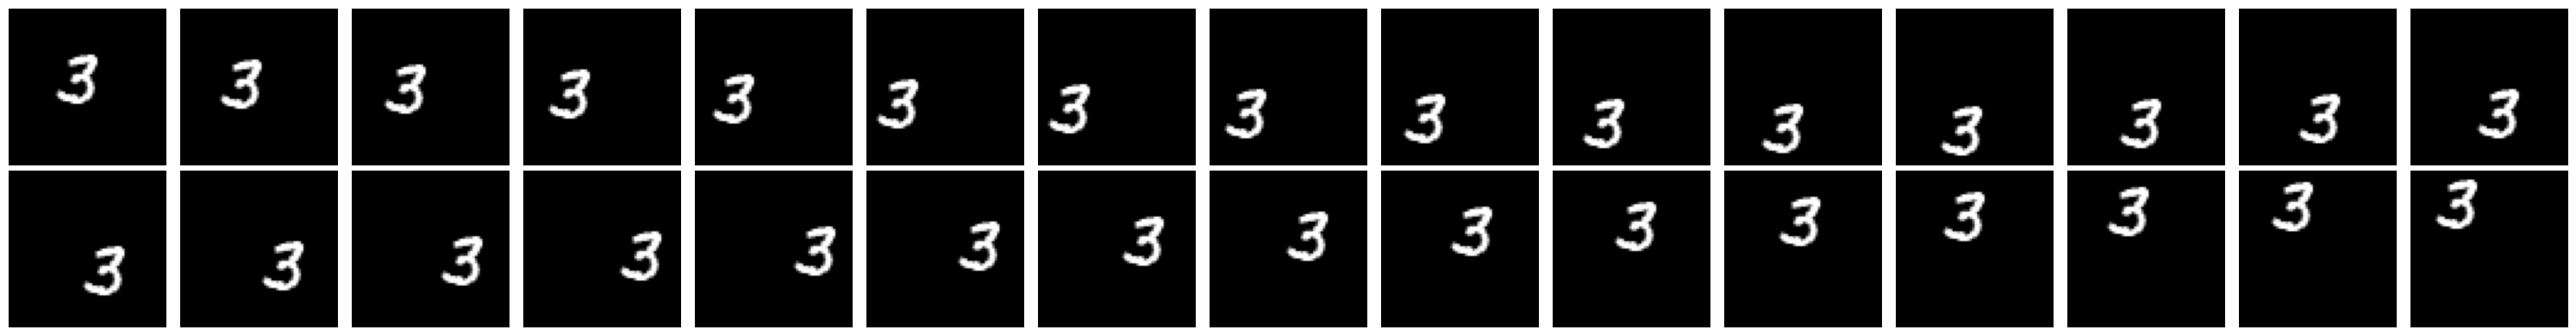

 ********** SNN Training **********

Epoch [1/4], Step [800/800], Training Loss: 45.45293 Time elasped:203.16 s | SNN Test Accuracy: 76.872 | 
Epoch [2/4], Step [800/800], Training Loss: 38.90832 Time elasped:202.00 s | SNN Test Accuracy: 82.969 | 
Epoch [3/4], Step [800/800], Training Loss: 38.16823 Time elasped:202.04 s | SNN Test Accuracy: 84.291 | 
Epoch [4/4], Step [800/800], Training Loss: 38.08755 Time elasped:202.44 s | SNN Test Accuracy: 84.419 | 

In [18]:
# MNIST(2) -> MovingMNIST(4)

time_window = 20
max_rate = 400

batch_size = 100
num_batches = 800
num_epochs = 2


SNN = Network_SNN(time_window=time_window, max_rate=max_rate)
SNN.to(device)
SNN.load_state_dict(Normalized_Target.state_dict())

MovingMNIST = BouncingMNISTDataHandler(batch_size=batch_size, seq_length=time_window, image_size=img_size,
                                      path='/kaggle/input/mnist-h5/mnist.h5')

SNN_Params = {
    'seq_length' : time_window, 'num_batches' : num_batches, 'num_epochs' : num_epochs,
    'optimizer' : optim.Adam(SNN.parameters()), 'criterion' : nn.MSELoss().to(device),
    'infer_type' : 'Ordin', 'best_acc' : 0
}


OrdinTrainNEval(SNN, SNN_Params, mnist_train_loader, mnist_test_loader, arc='SNN', verbose_interval=1); print('\n')

SNN_Params['infer_type'] = 'Synth'
MovingMNIST.seq_length_ = 30

SNN.time_window = 30
SNN.max_rate = 800
SNN.rescale_factor = 1.0/(SNN.dt*SNN.max_rate)

SNN_Params['seq_length'] = SNN.time_window
SNN_Params['num_epochs'] = 4

SynthTrainNEval(MovingMNIST, SNN, SNN_Params, verbose_interval=1)

In [24]:
SNN_Params['infer_type'] = 'Ordin'
OrdinEval(SNN, SNN_Params, test_loader=mnist_test_loader, arc='SNN'); print('\n')

AttackNetworks(ANN, SNN, SNN_Params, epsilon_range, arc='SNN')

SNN Test Acc: 23.970 | 

Perturbation Strength: 0.15
SNN (fast_gradient_method) Perturbed Data Accuracy: 12.530
SNN (projected_gradient_descent) Perturbed Data Accuracy: 9.610

{'fast_gradient_method': [12.53], 'projected_gradient_descent': [9.61]}


In [20]:
# MNIST(2)

time_window = 30
max_rate = 800
num_epochs = 2


JustSNN = Network_SNN(time_window=time_window, max_rate=max_rate)
JustSNN.to(device)
JustSNN.load_state_dict(Normalized_Target.state_dict())

JustSNN_Params = {'num_epochs' : num_epochs, 'optimizer' : optim.Adam(JustSNN.parameters()),
                  'criterion' : nn.MSELoss().to(device), 'infer_type' : 'Ordin', 'best_acc' : 0}

# OrdinEval(JustSNN, JustSNN_Params, test_loader=mnist_test_loader, arc='SNN'); print('\n')


OrdinTrainNEval(JustSNN, JustSNN_Params, mnist_train_loader, mnist_test_loader, arc='SNN', verbose_interval=1); print('\n')

AttackNetworks(ANN, JustSNN, JustSNN_Params, epsilon_range, arc='SNN')

Network_SNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (subsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (subsample2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=False)
  (HalfRect3): ReLU()
) 
Parameter Count: 86672 

 ********** SNN Training **********

Epoch [1/2], Step [600/600], Training Loss: 10.19577 Time elasped:144.37 s | SNN Train Acc: 98.137 | SNN Test Acc: 98.154 | 
Epoch [2/2], Step [600/600], Training Loss: 7.22430 Time elasped:144.43 s | SNN Train Acc: 98.417 | SNN Test Acc: 98.419 | 

Perturbation Strength: 0.1
SNN (fast_gradient_method) Perturbed Data Accuracy: 94.970
SNN (proje

In [21]:
# for model, name in [(ANN, 'ANN_99.08'), (Target, '98.99'), (SNN, 'Hybrid+|SNN_84.42'), (JustSNN, 'Hybrid|SNN_98.42')]:
#     torch.save(model, name+'.pth')
#     print(name, 'Saved!')

ANN_99.08 Saved!
98.99 Saved!
Hybrid+|SNN_84.42 Saved!
Hybrid|SNN_98.42 Saved!


In [25]:
AttackNetworks(ANN, JustSNN, JustSNN_Params, epsilon_range, arc='SNN')

Perturbation Strength: 0.15
SNN (fast_gradient_method) Perturbed Data Accuracy: 84.870
SNN (projected_gradient_descent) Perturbed Data Accuracy: 41.720

{'fast_gradient_method': [84.87], 'projected_gradient_descent': [41.72]}
